# DSMCER Notebook 9 - Feature Engineering 2

1. More feature extraction
   1. _Poll_: List some possible features
   2. Molecules
2. Feature selection
   1. By filtering
   2. _Exercise_: By Lasso selection
   3. Forward selection
   4. PCA
   5. _Exercise_: Interpretting the PCs
   6. _Exercise_: Reverse selection

In [ ]:
import time
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.ensemble

import codecarbon

# ! NEW
import sklearn.feature_selection
import sklearn.decomposition
import rdkit.Chem
import rdkit.Chem.Descriptors
import rdkit.Chem.rdMolDescriptors
import rdkit.ML.Descriptors.MoleculeDescriptors

***
***

## 1. More feature extraction

<font size=5><center> In our first SML lecture, we encoded nominal variables (the identity of DES agents) with OneHotEncoding:

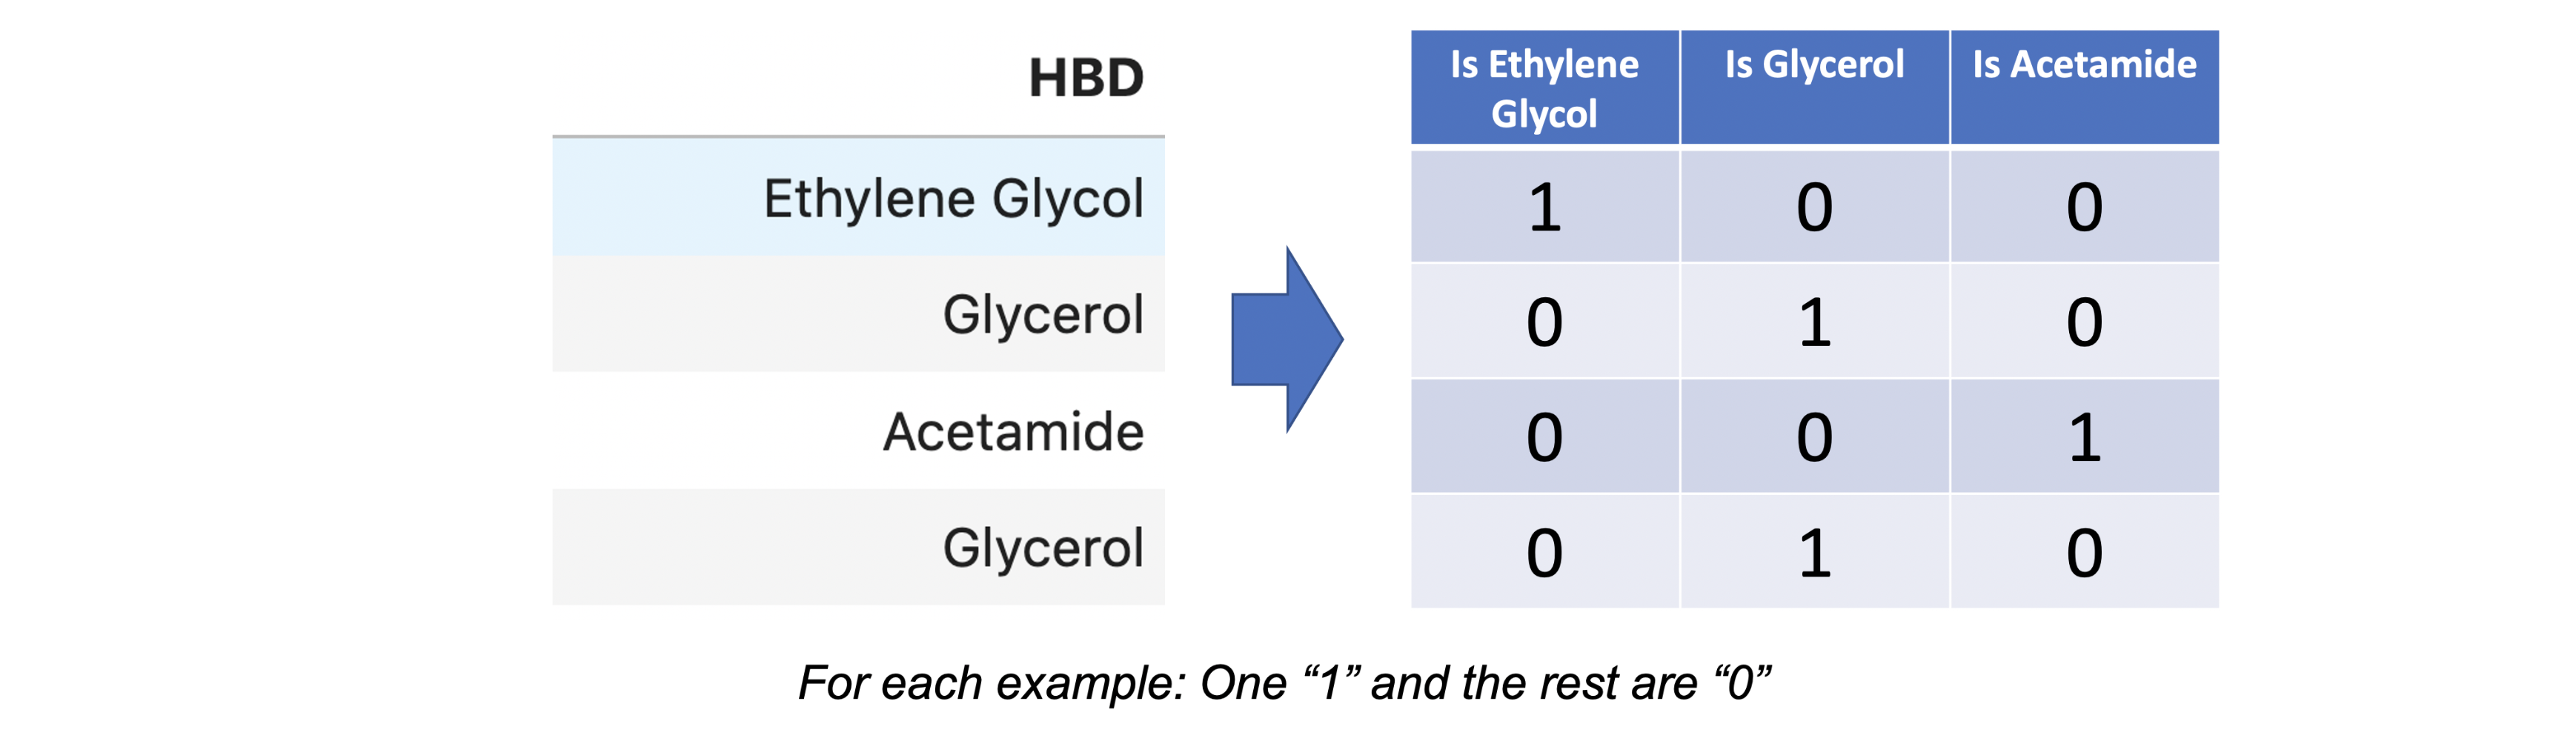

<font size=5><center> This was a rudimentary form of *feature selection*, but it is limited to the case when future examples __never have new nominal values__. 

***

### A. _Poll_: List some possible features

<font size=4> To create an SML model that would function __for new molecules not seen in training__ we had to engineer some new features that we expected to effect the DES mixture like molar mass and melting point. 
    
<font size=4><center> __Consider the following problem statement__: Create a predictor of human longevity.</center>
    
<font size=4>It would not be useful to OneHotEncode people, because the people we want to make predictions for are different from the ones we can take data for. __List some features we could extract from a person to try to predict their lifespan__?

***

### B. Molecules

<font size=5><center> __What features we can extract are task dependant__, but there are common things we can do for molecules and materials. 

<font size=4>__Hopefully working through this example of extracting features for molecules will give you a bigger picture of feature extraction for other examples__. It may also be that you end up working with molecules. Enter the `rdkit` molecules object:

In [ ]:
help(rdkit.Chem.Mol)

In [ ]:
benzene = rdkit.Chem.MolFromSmiles('c1ccccc1')
benzene

<font size=4>*A note on "SMILES" stings. [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) (__S__ implified __M__ olecular-__I__ nput __L__ ine-__E__ ntry __S__ tring) defines the atoms in a molecule and the bonding pattern of the atoms. Please see the resource for more information.*

<font size=4>`rdkit` allows us to quickly extract many features from the SMILES string:

In [ ]:
my_features = ['MolLogP', 'NumAromaticRings', 'MolWt']

In [ ]:
calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(my_features)

In [ ]:
calculator.CalcDescriptors(benzene)

<font size=4>Instead of chosing specific descriptors, we might just extract them all... that is where the next section comes in ;)

In [ ]:
all_descriptors = [name for name, _ in rdkit.Chem.Descriptors._descList]
print(all_descriptors)

In [ ]:
calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(all_descriptors)

In [ ]:
features = calculator.CalcDescriptors(benzene)
print(features)

<font size=4>Each one of these __describes something physically interpretable about the molecule__. This type of feature is called a *descriptor*. 
    
<font size=4>Let's extract some descriptors for the HCEPDB dataset.

***

In [ ]:
# load the data by downloading it
df = pd.read_csv('http://faculty.washington.edu/dacb/HCEPDB_moldata.zip').sample(500, random_state=201)

<font size=4>Use the smiles to compute features

In [ ]:
my_features = ['FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR']
my_calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(my_features)

def smiles_to_descriptors(smiles, calculator=my_calculator):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    descriptors = calculator.CalcDescriptors(mol)
    return descriptors

In [ ]:
descriptors = np.vstack(
    df['SMILES_str'].apply(smiles_to_descriptors))

<font size=4>__Notice how there were some errors?__ I won't dive into why, but suffice it to say that some of these descriptors don't work for certain types of molecules. In this case, RDKit gives back "-666" (spooky). There aren't really values, we want to replace these with `NaN` to make sure they don't slip through to the ML model

In [ ]:
np.isclose(descriptors, -666.0).sum()

<font size=4>Add all the data back into a dataframe to make this easier

In [ ]:
new_df = pd.DataFrame(descriptors)
new_df = new_df.rename(columns=lambda col_name: f"x{col_name}")

In [ ]:
new_df['y'] = df['e_gap_alpha'].values

<font size=4>Fix all of the -666

In [ ]:
new_df = new_df.replace(to_replace=-666.0, value=None).astype('Float64')

In [ ]:
new_df.describe()

<font size=5><center>__Why don't we just use all of these features...?__

***

## 2. Feature Selection

<font size=4> One of the first things we often do is handle Null values. The ML model cannot deal with Null values. __We have a few options:__
    
1. <font size=4> Remove the datapoints that have nans. This is a good choice if there are only a few or you have __a lot__ of data
    
2. <font size=4> __Impute them__, for example by filling the Null values with the average over the rest of the data. We will not cover this explicity but if you have lots of Null values or a small dataset, it may be worth it. See more information [here](https://scikit-learn.org/stable/modules/impute.html|) 

In [ ]:
new_df.isna().any(axis=1).sum()

<font size=4>There is only a single example in the dataset with NaN values, let's just drop them.

In [ ]:
new_df = new_df.dropna()

In [ ]:
new_df.shape

<font size=4>We are doing machine learning. Remember __we must always__ save a test set and put it aside until the end. For a goal of "Predict energy gap for new compounds" a random split is likely sufficient, assuming we are not using new elements in the future. 

In [ ]:
dev, test = sklearn.model_selection.train_test_split(new_df, test_size=.15, random_state=1)

<font size=5><center>Feature selection is concerned with __determining if any of our features are not useful or just extra noise.__

<font size=3> Let's look at a visual to get an idea:

In [ ]:
sns.pairplot(dev)

<font size=4>There are clearly some relationships to observe:

- <font size=4> $x16$ takes on only a single value in the whole dataset

- <font size=4> $x1$ and $x19$ are highly correlated

### A. By filtering

<font size=5><center>Before we do anything clever we can __just compute some measures of the data itself independant of any ML model__. We can use these to filter out some features.

<font size=4>Which data are related to the target according for example pearson correlation coefficient? There are other measures of correlation, see [here](https://www.analyticsvidhya.com/blog/2021/09/different-type-of-correlation-metrics-used-by-data-scientist/).

In [ ]:
dev.corr(method='pearson')['y']

<font size=4>There is a low hanging fruit here - features 14 15 and 16 have `NaN` correlation. This means the pearson-r mathematically could not be calculate. These are the features that are the same value for the full dataset, and we can definately remove them.

In [ ]:
dev = dev.drop(columns=['x14', 'x15', 'x16'])
test = test.drop(columns=['x14', 'x15', 'x16'])

<font size=4>We might also chose to remove features with __low correlation__:

In [ ]:
dev.corr(method='pearson')['y'].abs() < 0.03

In [ ]:
features_to_remove = ['x8']

In [ ]:
dev.drop(columns=features_to_remove)

<font size=4>We have 16 features remaining after filtering!

***

<font size=5><center>Note that __removing features with pearson cannot capture nonlinear relationships__! Consider the following...

In [ ]:
x = np.linspace(0,np.pi)
y = np.sin(x)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x,y)

In [ ]:
print(f'Pearson corr for this sin data: {scipy.stats.pearsonr(x,y)}')

<font size=5><center>Clearly there is a relationship, but pearson doesn't think so, so be careful with this method.

***

### B. _Exercise_: By LASSO selection

<font size=4>Remember L1 regression (LASSO)? It can be used to select features.

In [ ]:
train, val = sklearn.model_selection.train_test_split(new_df, test_size=.15, random_state=1)

In [ ]:
def get_X_y(df):
    x_columns = [c for c in df.columns if 'x' in c]
    
    return df[x_columns].values, df['y'].to_numpy().reshape(-1,1)

In [ ]:
train_X, train_y = get_X_y(train)
val_X, val_y = get_X_y(val)

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
val_X_scaled = scaler.transform(val_X)

<font size=4>Choose a value of `alpha` and train a LASSO model on the dev set. What are the weights (`model._coef`) of the model? Change `alpha` and retrain. What do you observe? (*Hint: start from a very low alpha*)

<font size=4>Note the "null model" of guessing the dev set mean.

In [ ]:
null_error = np.abs(val_y - train_y.mean()).mean()
print(null_error)

<font size=4>How good is our model?

In [ ]:
sklearn.metrics.mean_absolute_error(val_y, model.predict(val_X_scaled))

<font size=4>Not much better... this is the reason that high alpha returns all 0s for this application. The linear model is not much better than the null model, so __even a small amount of regularization pushes the model to guess the mean__.

<font size=4>When the problem is __highly nonlinear__ or when the __features we are starting with are just not good in the first place__, Lasso is not very helpful.

***

### C. By forward selection

<font size=5><center>We can overcome the linearity assumptions of filtering and Lasso with __brute force__.

<font size=4>Here we use a nonlinear model, maybe the architecture we plan to use in the end, to try features one by one:

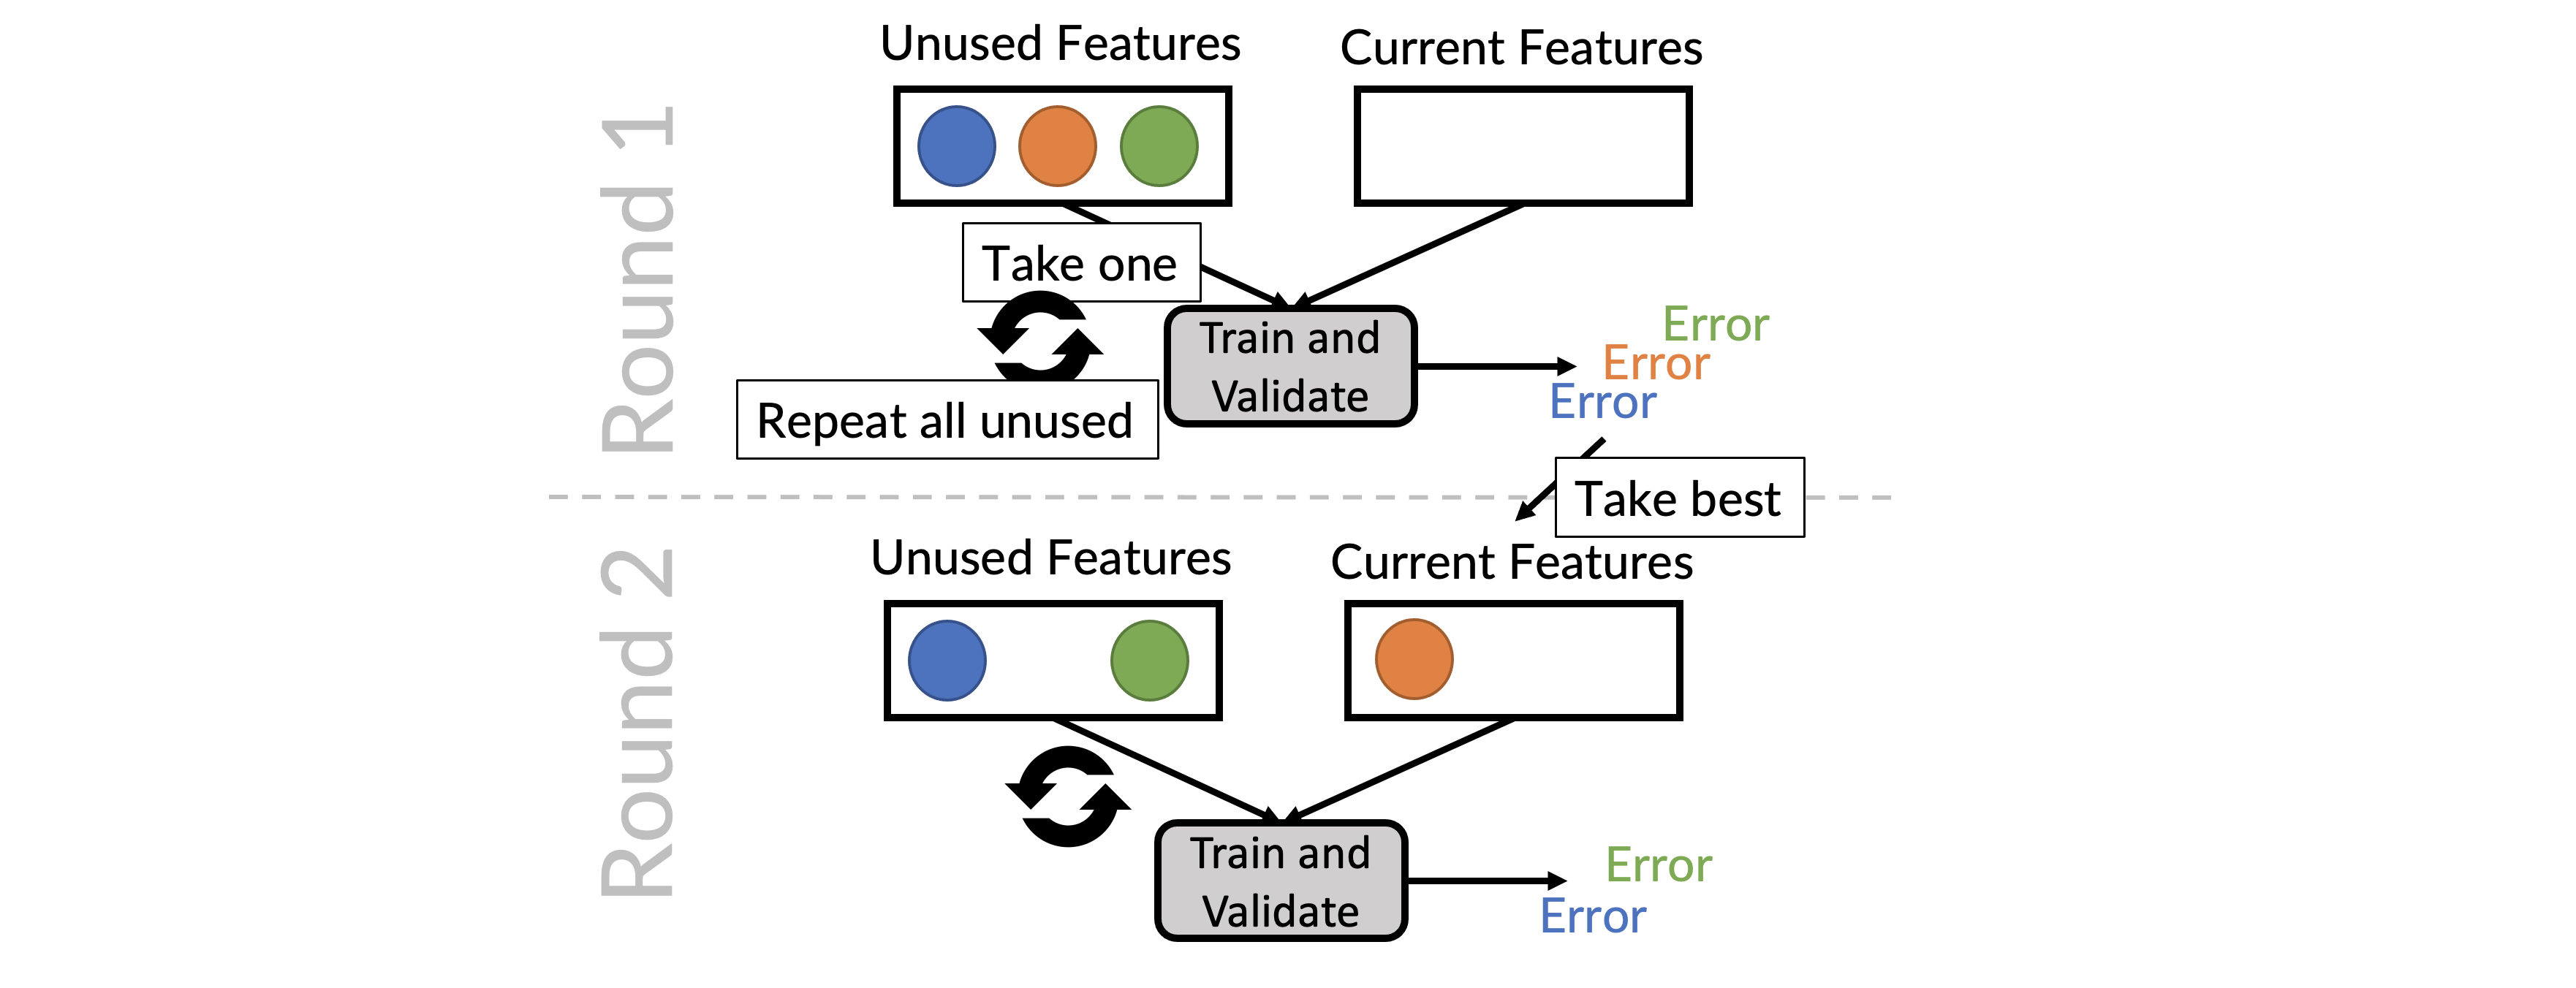

<font size=4>For comparison, let's use all features.

In [ ]:
dev_X, dev_y = get_X_y(dev)
test_X, test_y = get_X_y(test)

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X_scaled = scaler.fit_transform(dev_X)
test_X_scaled = scaler.transform(test_X)

In [ ]:
all_feat_model = sklearn.ensemble.RandomForestRegressor()
all_feat_model.fit(dev_X_scaled, dev_y)

In [ ]:
print(f"Model with all features MAE: {sklearn.metrics.mean_absolute_error(test_y, all_feat_model.predict(test_X_scaled))}")

<font size=4>`sklearn` has forward selection built in

In [ ]:
base_model = sklearn.ensemble.RandomForestRegressor()
selector = sklearn.feature_selection.SequentialFeatureSelector(
    base_model,
    n_features_to_select=5,
)

In [ ]:
selector.fit(dev_X_scaled, dev_y)

In [ ]:
dev_X_5 = selector.transform(dev_X_scaled)
test_X_5 = selector.transform(test_X_scaled)

In [ ]:
test_X_5.shape

<font size=4>How does a model using these features compare to all features?

In [ ]:
five_feat_model = sklearn.ensemble.RandomForestRegressor()
five_feat_model.fit(dev_X_5, dev_y)

In [ ]:
print(f"Model with 5 features MAE: {sklearn.metrics.mean_absolute_error(test_y, five_feat_model.predict(test_X_5))}")

<font size=5><center>The model with 5/17 features almost as well as the model with all features. 

<font size=4> *Note*: intead of selected 5 features exactly, we can have the selector keep adding features __until the performance stops improving.__ See the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector).

### D. _Poll_: Forward selection disadvantages

<font size=4>The advantage of this method is that is won't get tripped up by nonlinear relationships between $X$ and $y$. Can you think of any disadvantages?

### E. By PCA

<font size=4>Remember features that we observed were highly correlated? Consider the following:

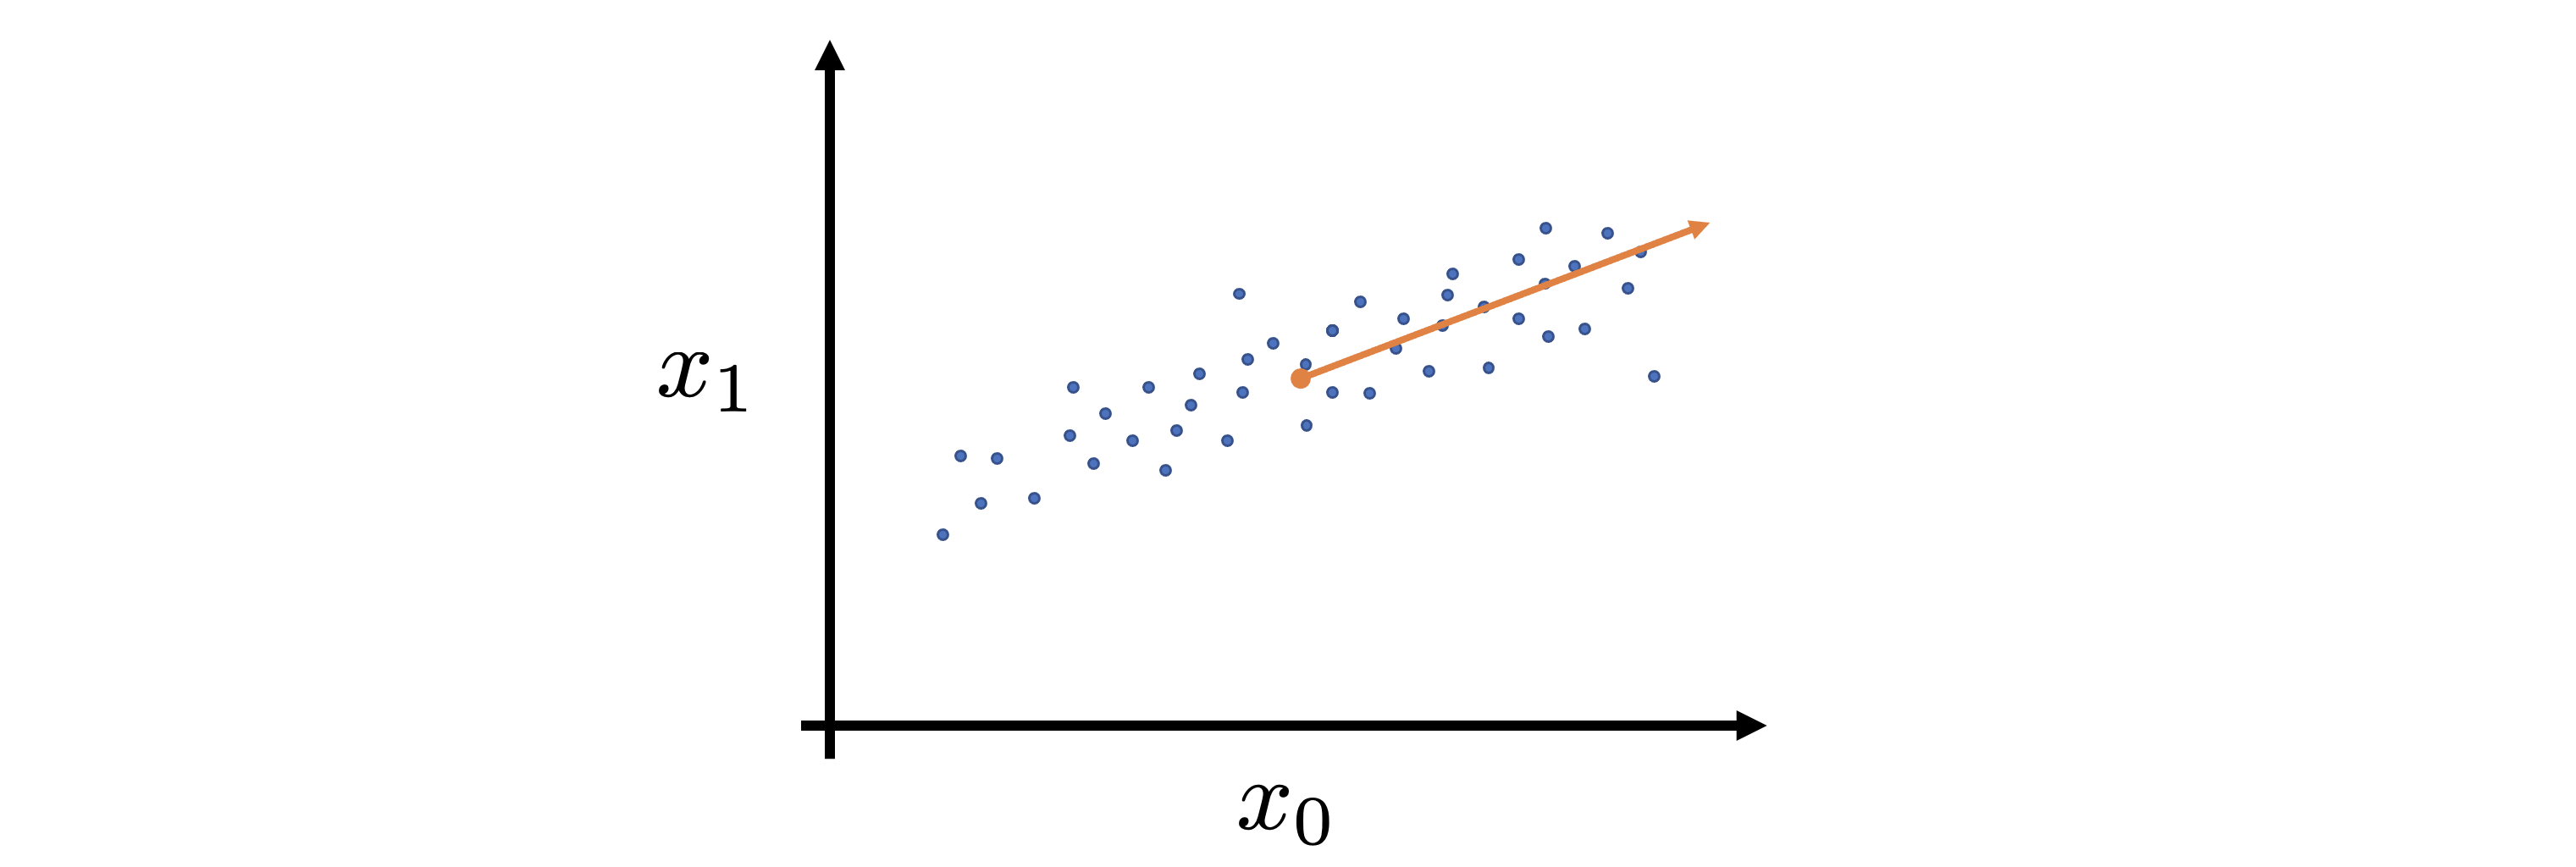

<font size=4>Instead of specifying the data with ($x_0$, $x_1$) pairs, what if we just used postition along the vector?

<font size=5><center>Principal Component Analysis (PCA) maps the data to __a lower dimensional space while maintaining as much information as possible__.

<font size=4>More technically, it finds the component (a linear combination of features) that captures the most variance. Then it repeats, finding an __orthoganol__ component that captures the next most variance.

<font size=4>The **first** principal component of our set of features $X = \left\{x_0,x_1,...,x_p\right\}$ is the linear combination

<font size=4>$$z_0 = \phi_{0,0}x_0 \,+\, \phi_{1,0}x_1 \,+\, ...\,+\,\phi_{p,0}x_p$$

<font size=4>__which has the largest variance__. The coefficients $\left\{\phi_{1,i}\right\}_{i=1}^{p}$ are called _loadings_ of the first principal component. The _loadings_ are such that $z_0$ is normalized, i.e. $\sum_i^p\phi_{i,0}^2=1$

<font size=4>The **second** principal component is the direction which maximizes variance among all directions orthogonal to the first. 

<font size=4>The $k$-th component is the variance-maximizing direction orthogonal to the previous $k − 1$ components.


<font size=5><center>But how do we find the loadings to maximize the variance?

<font size=4>This is a singular value decomposition optimization problem out of scope for this class. More info [here](https://en.wikipedia.org/wiki/Principal_component_analysis). __Note that is is critically important that the data are standardized__.

<font size=4>We can easilly implement PCA with sklearn:

In [ ]:
pca = sklearn.decomposition.PCA(n_components=5)

# determine the PC's
dev_PCs = pca.fit_transform(dev_X_scaled)
test_PCs = pca.transform(test_X_scaled)

<font size=4>We can plot the first two principle, which should capture the first and second most variance:

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,3))

axes[0].set_xlabel('PC0')
axes[0].set_ylabel('PC1')
axes[0].scatter(dev_PCs[:,0], dev_PCs[:,1], s=2)
axes[0].set_title('PC0 vs PC1')

axes[1].set_xlabel('PC0')
axes[1].set_ylabel('y')
axes[1].scatter(dev_PCs[:,0], dev_y, s=2)
axes[1].set_title('PC0 vs y')

axes[2].set_xlabel('PC1')
axes[2].set_ylabel('y')
axes[2].scatter(dev_PCs[:,1], dev_y, s=2)
axes[2].set_title('PC1 vs y')

<font size=5><center>__PCA allows to reduce our dimensionality to a new set of features__, and also confirmed to us that our set of features are weak features for the target of interest. ($^*$using standard ML models)

In [ ]:
pca_model = sklearn.ensemble.RandomForestRegressor()
pca_model.fit(dev_PCs, dev_y)

In [ ]:
print(f"Model with PCA features MAE: {sklearn.metrics.mean_absolute_error(test_y, pca_model.predict(test_PCs))}")

<font size=4>Same performance as forward selecting 5 features without all of the brute force.

### F. Interpretting the PCs

<font size=4>When we filtered, Lasso, or forward selected, the results were very interpretable - some specific features what we already computed were better than others. Can we interpret PCs?

<font size=4>Determine the amount of the total variance explained by these 5 principle components, as well as the original feature that contributes most heavily to the first PC.

In [ ]:
pca.explained_variance_ratio_.sum()

<font size=4>The 5 PCs explain 89% of the variance of the original 17 features.

In [ ]:
pca.components_[0]

In [ ]:
most_important_feat_index = np.argmax(np.abs(pca.components_[0]))

In [ ]:
dev.columns[most_important_feat_index]

<font size=4>$x_9$ contributes most to the first PC but it does not dominate.

<font size=5><center>When the features you start with are interpretable descriptors, PCA removes some of the intepretability!

***

<font size=4>PCA also assumes __linear relationship between features__ (different than linear relationship to target):

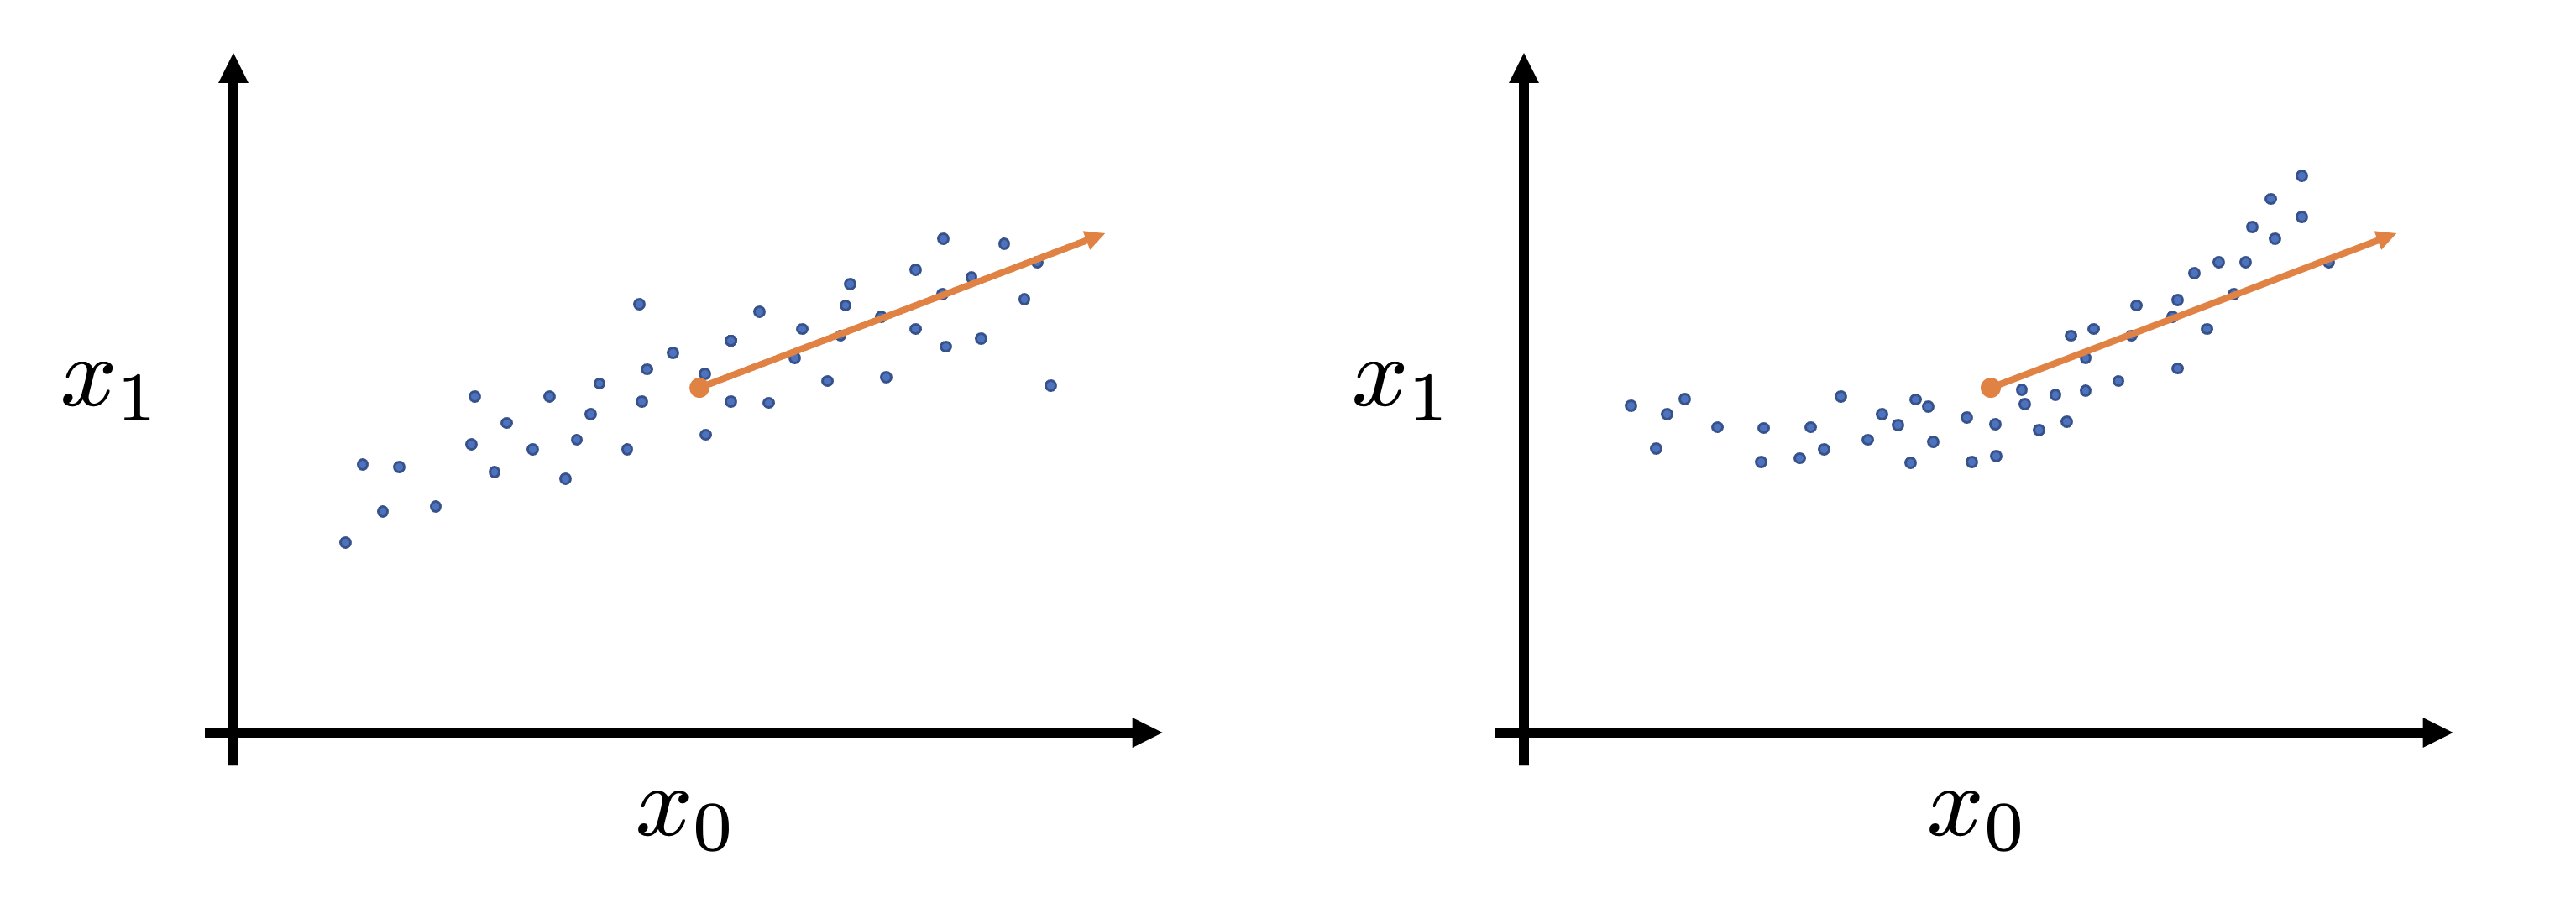

<font size=4>Same first PC, same Variance explained. Uncaptured variance in the left is linear and resembles noise, in the right it is clearly a relationship we miss.

***

<font size=4> The general functional for for 3 features: 
    
<font size=4> $$\hat{y} = f(x_0,x_1,x_2)$$
    
<font size=4> Linear independance of features:
    
<font size=4> $$\hat{y} = f(x_0) + f(x_1) +f(x_2)$$
    
<font size=4> Linear relationship between x and y:
    
<font size=4> $$\hat{y} = L[x_0, x_1, x_2] = w_0x_0 + w_1x_1 +w_2x_2$$

<font size=4> Linear relationship between features:
    
<font size=4> $$\hat{y} = f(x_0,x_1,x_2) = f(L[x_1, x_2], L[x_0, x_2],L[x_0, x_1])$$


| Type      | Pros | Cons | When |
| ----------- | ---------------- | ---------------- |  -------------------------------- | 
| Filtering        | Interpretable, cheap | Assumes linear relationship b/w x and y* |  As a first pass, as data exploration | 
| Lasso     | Interpretable, cheap  | Assumes linear relationship b/w x and y | As a first pass, as data exploration |
| PCA         | Better dimensionaility reduction, purely unsupervised | Loss of interpretability, assumes linear feature relationships, can be costly for large data sets  | You have many features (careful: always check how much variance your PCs capture) |
| Forward selection        | Can capture nonlinear relationships to target | Assumes linear independance of features, __much more costly__  | You have very nonlinear relationships, eg you do not observe clear correlations in filtering or a lasso model isn't much better than null |


### F. Reverse Selection

<font size=4>Forward selection is quite costly, given that we have to train many (larger and larger) models. It allows us to deal with nonlinear $y(x)$ relationships, __but it still assumes features are independant__. Consider a situation with 5 possible features, and we ask for 3 to be selected with forward selection:

| Model uses | Model Error |
| ----------- | ---------------- |
| $x_0$, $x_1$, $x_2$ | Very Low | 
| $x_0$, $x_1$ | Low |
| $x_0$ | High |
| $x_1$ | High |
| $x_2$ | High |
| $x_3$ | Med |
| $x_4$ | Med |

<font size=4>Forward selection would never select $x_0$, $x_1$, and $x_2$. 

<font size=5><center>Reverse selection __starts with all features instead of none__, and checks which features cause the model performance to suffer the most. Unfortunately, it is extra costly

<font size=4>Consider a feature set of 20 features, and we want to select 10. Assume that the cost of training a model is equal to its number of features, eg a model trained with 5 features is 5 times as expensive as a model with 1 feature. __How much more expensive is reverse selection__?

## Summary

## Summary
- <font size=4> We introduced `codecarbon` a more rigorous way to track cost of computation than walltime
- <font size=4> We reviewed Linear models (basic regression, regularized regression, and logistic regression) and showed some pros and cons
- <font size=4> We introduced some new model types: Decision trees, random forests, and kernel methods such as kernel ridge regression, SVM, and gaussian processes
- <font size=4> We used Xgboost which is a __bagged, boosted decision tree ensemble taken to the extreme__ which is often the go-to when a set of good features can be produced

<font size=5>__A challenge for you__ - Compute all RDKit descriptors available on this dataset of 500, and use Reverse Feature selection to __remove features until there are only 10__. How much carbon did it cost approximately? what would happen if the dataset were 5000 instead of 500?